In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.5 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

alphas1
alphas2
Train acc 0.23330890191897655
Val acc 0.34414978678038377
Train acc 0.4155450426439232
Val acc 0.4490605010660981
Train acc 0.5054304371002132
Val acc 0.5359474946695096
Train acc 0.5534381663113006
Val acc 0.5610341151385928
Train acc 0.5866871002132196
Val acc 0.6097414712153518
Train acc 0.6218350213219617
Val acc 0.6337286780383795
Train acc 0.6358275586353944
Val acc 0.6376599147121536
Train acc 0.6593483475479744
Val acc 0.6629797441364605
Train acc 0.6702425373134329
Val acc 0.660047974413646
Train acc 0.6955623667377399
Val acc 0.6606476545842217
Train acc 0.6929970682302772
Val acc 0.6988272921108742
Train acc 0.7009261727078892
Val acc 0.6962953091684435
Train acc 0.6828358208955224
Val acc 0.7014259061833689
Train acc 0.7040245202558635
Val acc 0.715018656716418
Train acc 0.7089552238805971
Val acc 0.7149853411513859
Train acc 0.7062233475479744
Val acc 0.7124200426439232
Train acc 0.7065231876332623
Val acc 0.7048240938166311
Train acc 0.718816631130064
Val 

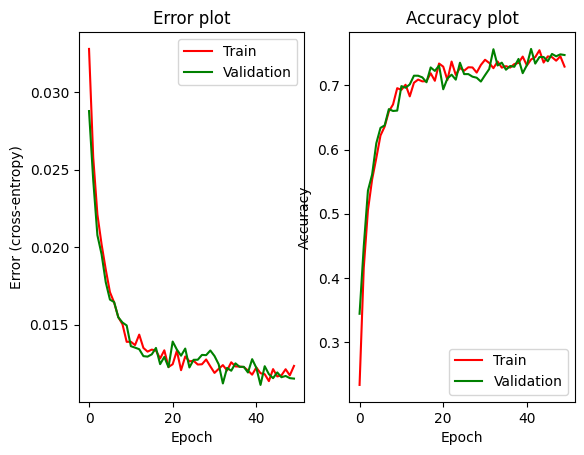

Test accuracy : 0.7249


In [3]:
from tiny_model import Net
param_list = []
model = Net(4,4,20,'gdas').cuda()
for n,p in model.named_parameters():
    if "alpha" not in n:
        param_list.append(p)
    else:
        print(n)

optimizer = torch.optim.SGD(param_list,lr=0.1)
optimizer_arch = torch.optim.Adam([model.alphas1,model.alphas2],lr=0.001,weight_decay = 1e-3)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
tau = torch.Tensor([0.1])
tau_step = (10 - 0.1) / 50
tau_curr = tau
for i in range(50):
  total_loss = 0
  total_acc = 0  
  c = 0
  for (images,labels), (images_val,labels_val) in zip(train_loader,val_loader):
    images = images.cuda()
    labels = labels.cuda()
    images_val = images_val.cuda()
    labels_val = labels_val.cuda()    
    optimizer.zero_grad()
    output = model(images,tau_curr)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    optimizer_arch.zero_grad()
    output_val = model(images_val,tau_curr)
    loss_val = criterion(output_val,labels_val)
    loss_val.backward()
    optimizer_arch.step()    
    total_loss+=loss.item()
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
    c+=1
  tau_curr += tau_step  
  
  #validation
  
  total_loss_val = 0
  total_acc_val = 0
  c = 0
  for images,labels in val_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images,tau_curr)
    loss = criterion(output,labels)
    
    total_loss_val +=loss.item()
    total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    c+=1
  train_errors.append(total_loss/n_train)
  train_acc.append(total_acc/n_train)
  val_errors.append(total_loss_val/n_val)
  val_acc.append(total_acc_val/n_val)
  print("Train acc",train_acc[-1])
  print("Val acc",val_acc[-1])  
print("Training complete")

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()

total_acc = 0
for images,labels in test_loader:
  images = images.cuda()
  labels = labels.cuda()
  output = model(images,tau_curr)
  total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
    
print("Test accuracy :",total_acc/len(test_loader.dataset))

In [4]:
print(torch.argmax(torch.nn.functional.softmax(model.alphas1,dim=-1)))
print(torch.argmax(torch.nn.functional.softmax(model.alphas2,dim=-1)))

tensor(9, device='cuda:0')
tensor(5, device='cuda:0')


In [16]:
torch.nn.functional.softmax(model.alphas1,dim=-1)

tensor([0.0668, 0.0687, 0.0651, 0.0660, 0.0673, 0.0656, 0.0665, 0.0664, 0.0668,
        0.0663, 0.0670, 0.0662, 0.0670, 0.0670, 0.0672], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Train acc 0.7987083333333334
Val acc 0.9154753989361702
Train acc 0.9136875
Val acc 0.9266954787234043
Train acc 0.9273333333333333
Val acc 0.9331781914893617
Train acc 0.9342291666666667
Val acc 0.9379155585106383
Train acc 0.9393333333333334
Val acc 0.9389128989361702
Train acc 0.9406041666666667
Val acc 0.9360039893617021
Train acc 0.9445833333333333
Val acc 0.9424867021276596
Train acc 0.944875
Val acc 0.9436502659574468
Train acc 0.9474583333333333
Val acc 0.9466422872340425
Train acc 0.9486875
Val acc 0.9434009308510638
Train acc 0.9494375
Val acc 0.9485538563829787
Train acc 0.9510208333333333
Val acc 0.9431515957446809
Train acc 0.9518958333333334
Val acc 0.9434840425531915
Train acc 0.953
Val acc 0.9355884308510638
Train acc 0.9543541666666666
Val acc 0.9509640957446809
Train acc 0.9542916666666666
Val acc 0.9473902925531915
Train acc 0.9555416666666666
Val acc 0.9496343085106383
Train acc 0.9547708333333333
Val acc 0.9507978723404256
Train acc 0.9564375
Val acc 0.952376994680

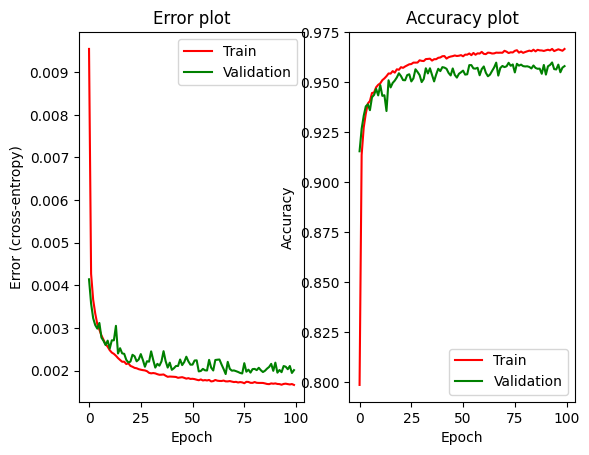

Test accuracy : 0.9631


In [5]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision.datasets as datasets
from torch.autograd import Variable
import torchvision
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)
dict_test_accs = {}
idx1 = 9
idx2 = 5
from tiny_model import NetDiscrete
model = NetDiscrete(4,4,20,idx1,idx2).cuda()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)
criterion = nn.CrossEntropyLoss()
batch_size = 64
train_errors = []
train_acc = []
val_errors = []
val_acc = []
n_train = len(train_loader)*batch_size
n_val = len(val_loader)*batch_size
for i in range(100):
    total_loss = 0
    total_acc = 0
    c = 0
    for (images,labels) in train_loader:
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0    
        c+=1
        #validation
        total_loss_val = 0
        total_acc_val = 0
        c = 0
    for images,labels in val_loader:
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        loss = criterion(output,labels)
        total_loss_val +=loss.item()
        total_acc_val +=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
        c+=1
    train_errors.append(total_loss/n_train)
    train_acc.append(total_acc/n_train)
    val_errors.append(total_loss_val/n_val)
    val_acc.append(total_acc_val/n_val)
    print("Train acc",train_acc[-1])
    print("Val acc",val_acc[-1])
print("Training complete")
print(idx1,idx2)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].plot(train_errors, 'r',label="Train")
ax[0].plot(val_errors, 'g', label="Validation")
ax[0].set_title("Error plot")
ax[0].set_ylabel("Error (cross-entropy)")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(train_acc, 'r',label="Train")
ax[1].plot(val_acc, 'g', label="Validation")
ax[1].set_title("Accuracy plot")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()
plt.show()
total_acc = 0
for images,labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    output = model(images)
    total_acc+=torch.sum(torch.max(output,dim=1)[1]==labels).item()*1.0
print("Test accuracy :",total_acc/len(test_loader.dataset))
test_acc = total_acc/len(test_loader.dataset)
dict_test_accs[(idx1,idx2)]= test_acc